In [1]:
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from torchvision.models import resnet101
from advertorch.utils import predict_from_logits
from advertorch.utils import NormalizeByChannelMeanStd

normalize = NormalizeByChannelMeanStd(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model = resnet101(pretrained=True)
model.eval()
model = nn.Sequential(normalize, model)
model = model.to(device)

In [3]:
from advertorch_examples.utils import ImageNetClassNameLookup
from advertorch_examples.utils import bhwc2bchw
from advertorch_examples.utils import bchw2bhwc
from skimage.io import imread

# img_path = 'giant_panda.jpg'
img_path = 'great_grey_owl.jpeg'
# img_path = 'goldfish.jpeg'

In [4]:
imagenet_label2classname = ImageNetClassNameLookup()
np_img = imread(img_path) / 255.

img = torch.tensor(bhwc2bchw(np_img))[None, :, :, :].float().to(device)
index = predict_from_logits(model(img))
cls_label = imagenet_label2classname(index)
print("Class name:", cls_label)

label = torch.tensor([index, ]).long().to(device)

Class name: great_grey_owl


In [5]:
from advertorch.attacks import LinfPGDAttack

def tensor2npimg(tensor):
    return bchw2bhwc(tensor[0].cpu().numpy())

def _show_images(enhance=127):
    np_advimg = tensor2npimg(advimg)
    np_perturb = tensor2npimg(advimg - img)

    pred = imagenet_label2classname(predict_from_logits(model(img)))
    advpred = imagenet_label2classname(predict_from_logits(model(advimg)))

    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(np_img)
    
    plt.axis("off")
    plt.title("original image\n prediction: {}".format(pred))
    plt.subplot(1, 3, 2)
    plt.imshow(np_perturb * enhance + 0.5)
    
    plt.axis("off")
    plt.title("the perturbation,\n enhanced {} times".format(enhance))
    plt.subplot(1, 3, 3)
    plt.imshow(np_advimg)
    plt.axis("off")
    plt.title("perturbed image\n prediction: {}".format(advpred))
    plt.show()

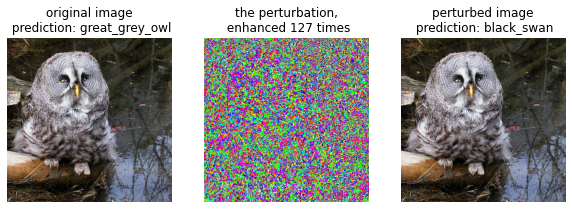

In [6]:
adversary = LinfPGDAttack(
    model, eps=1./255, eps_iter=1./255*2/40, nb_iter=40,
    rand_init=False, targeted=False)
advimg = adversary.perturb(img, label)
_show_images()